
# Data Processing Example - Fake TRKR

In [1]:
# General imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lmfit

import experimentdataanalysis.analysis.dataframe_plotting as dfplot

In [2]:
# import jtplot submodule from jupyterthemes IF installed
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=1.6)
    # set the default figure size
    jtplot.figsize(x=6., y=6.)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


## Simulation for creating fake data

b_external  kerr_rotation  probe_delay
run_id index_2d index_1d                                        
0      0        0              200.0      -0.000166       -480.0
                1              200.0      -0.000120       -452.0
                2              200.0      -0.000060       -424.0
                3              200.0      -0.000062       -396.0
                4              200.0       0.000057       -368.0

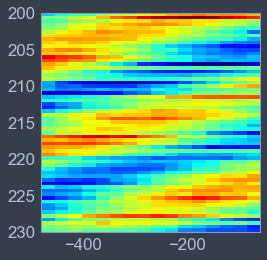

In [3]:
# import experimentdataanalysis.data_io.metadataparsing as metadataparsing  # for actual data importation
import experimentdataanalysis.simulations.simple_trkr_rsa_simulation as simple_trkr_rsa_simulation

# independent params
seed = 10

ndatasets = 61
nx = 16
dataset_bvals = np.linspace(200, 230, ndatasets)
tvals = np.linspace(-480, -60, nx)

# TEMP - full TRKR scans over huge B-range
# ndatasets = 51
# nx = 251
# dataset_bvals = np.linspace(0, 200, ndatasets)
# tvals = np.linspace(-500, 7000, nx)

# simulation constants & randomly generated params
simulation_constants = {
    'pulse_amplitude_mean': 1e-3,
    'pulse_amplitude_std_err': 2e-5,
    'gfactor': 0.439,
    'spin_lifetime_mean': 10000,
    'spin_lifetime_std_err': 2000,
    'initial_phase': 0.0 * np.pi,
    'extra_phase_offset_baseline': 0.0 * np.pi,
    'extra_phase_offset_cos_amp': 0.1 * np.pi,
    'extra_phase_offset_cos_nperiods': 3.0,
    'slopes_scale': 1e-10,
    'offsets_scale': 1e-4,
    'noise_scale': 2e-5,
}

simulation_params = \
    simple_trkr_rsa_simulation.generate_TRKR_simulation_params(nx, ndatasets,
                                                               simulation_constants, seed)
dataframe = \
    simple_trkr_rsa_simulation.generate_TRKR_simulation_dataframe(tvals, dataset_bvals,
                                                                  simulation_params,
                                                                  suppress_plot=True)

# plot newly created dataframe and show the first few rows
plt.figure(figsize=(4,4))
ax = plt.subplot(111)
dfplot.plot_dataframe_colorplot(dataframe, 'kerr_rotation',
                                x_values_column='probe_delay',
                                y_values_column='b_external',
                                ax=ax, aspect=1.0)
dataframe.head(5)

## Pandas-lmfit helper functions

In [4]:
from experimentdataanalysis.analysis.dataframe_processing \
    import df_extract_dataset_indexed_matrices, \
           df_extract_vector_lists_by_dataset, \
           df_transform_dataset_df_to_fit_row, \
           df_minimize_fcn_on_datasets, \
           df_minimize_fcn_across_linked_datasets

# df_extract_dataset_indexed_matrices(df, column_names)
# df_extract_vector_lists_by_dataset(df, column_names)
# df_transform_dataset_df_to_fit_row(df, group_fit_params_dict,
#                                    fit_params_to_add,
#                                    column_aggregation_dict={},
#                                    keep_const_columns=True)
# df_minimize_fcn_on_datasets(df, residuals_fcn, fit_params,
#                             independent_vars_columns,
#                             measured_data_column,
#                             *res_args,
#                             column_aggregation_dict={},  # KEYWORDS ONLY!
#                             keep_const_columns=True,
#                             **res_kwargs)

# WORK IN PROGRESS:
# df_minimize_fcn_across_linked_datasets(df, residuals_fcn, fit_params,
#                                        dataset_params_unpacking_fcn,
#                                        independent_vars_columns,
#                                        measured_data_column,
#                                        *res_args,
#                                        column_aggregation_dict={},  # KEYWORDS ONLY!
#                                        keep_const_columns=True,
#                                        **res_kwargs)

## Dataset fit model and residuals

In [5]:
# GLOBAL CONSTANTS
GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
LASER_REPRATE = 13158  # ps period

def fitfcn_cosine(delay_time, b_external,  # <- independent vars,
                  gfactor,  # <- potentially linked parameters across datasets in run,
                  amplitude, phase_offset,  # <- rest are unlinked parameters unique to current dataset
                  y_offset):
    """
    Oversimplified cosine fit that assumes phase @t=0 is always 0.
    Expected to act on very few data points, so brings in expected ang. freq using b_external.

    Independent variables: delay_time (can vary), b_external (must be const.)
    Parameters: gfactor, amplitude, phase_offset, y_offset

    IMPORTANT NOTE: Despite this function taking more than one independent variable,
    this model is ONLY 1D. Only the first should be allowed to vary during a run,
    the other independent variables are there for convenience when fitting to pandas
    dataframes and should really be thought of more as constant parameters (scalar
    values are not only acceptable, they are preferred for speed reasons to the
    alternative - arrays of same shape as first independent variable)
    """
    osc_ang_freq = 2 * np.pi * GFACTORCONSTANT * gfactor * b_external
    pos_def_delay = delay_time % LASER_REPRATE
    signal = amplitude * np.cos(osc_ang_freq * pos_def_delay + phase_offset)
    return signal + y_offset


def residuals_fitfcn_cosine(params, delay_time, b_external, measured_data=None):
    """
    Residual wrapper for lmfit minimize() for function fitfcn_cosine.
    Uses given parameters and independent variables to evaluate function.
    If data is given, returns (data - function_output) for use in least
    squares optimization. If data is not given or None, just returns
    the function output.

    Follows the style used in the lmfit documentation on minimize().
    """
    # unpack parameters:
    #  extract .value attribute for each parameter
    param_values = params.valuesdict()
    fitfcn_results = fitfcn_cosine(delay_time, b_external,
                                   **param_values)
#                                   gfactor, amplitude, phase_offset, y_offset)
    if measured_data is None:
        return fitfcn_results
    return fitfcn_results - measured_data

## Dataset fit parameter setup and constraints

In [6]:
from lmfit import Parameters

params_guesses = [('gfactor',        {'value' : 0.439,
                                      'vary'  : False}),
                  ('amplitude',      {'value' : 1e-3,
                                      'min'   : 0.0,
                                      'max'   : 1.0}),
                  ('phase_offset',   {'value' : 0.0,
                                      'min'   : -np.pi,
                                      'max'   : +np.pi}),
                  ('y_offset',       {'value' : 0.0,
                                      'min'   : -1e-3,
                                      'max'   : +1e-3}),
                 ]
fit_params = Parameters()
for param_name, param_guess_dict in params_guesses:
    fit_params.add(param_name, **param_guess_dict)

## 1D Fit to fake data

,b_external,gfactor,amplitude,amplitude_error,phase_offset,phase_offset_error,y_offset,y_offset_error
index_2d,,,,,,,,
0,200.0,0.439,0.000256,0.000010,0.064596,0.045979,6.130160e-05,0.000009
1,200.5,0.439,0.000344,0.000009,0.102096,0.022171,2.234415e-04,0.000007
2,201.0,0.439,0.000237,0.000015,0.245166,0.035119,5.969283e-07,0.000010
3,201.5,0.439,0.000264,0.000009,0.261802,0.016268,3.466837e-05,0.000006
4,202.0,0.439,0.000238,0.000017,0.311862,0.039501,-1.071235e-05,0.000012


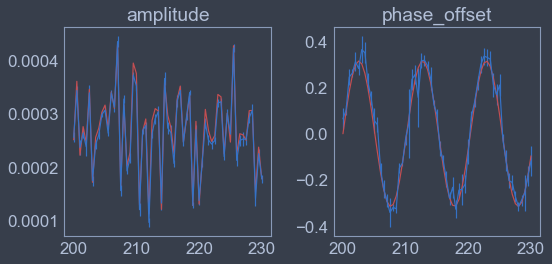

In [7]:
df = dataframe.xs(0, level='run_id')
residuals_fcn = residuals_fitfcn_cosine
fit_params = fit_params
independent_vars_columns = ["probe_delay", "b_external"]
measured_data_column = "kerr_rotation"
fit_params_to_add = ['amplitude', 'phase_offset']
column_aggregation_dict = {'time_elapsed': lambda x: x.head(1).values}  # keep first time
keep_const_columns = True

dataset_results, new_df = \
    df_minimize_fcn_on_datasets(df, residuals_fcn, fit_params,
                                independent_vars_columns,
                                measured_data_column,
                                column_aggregation_dict=column_aggregation_dict,  # keywords only!
                                keep_const_columns=keep_const_columns)

# FILTER OUT BAD FITS
good_result_indices = []
for dataset_index, result in enumerate(dataset_results):
    red_flag = False
    if result.params['phase_offset'].stderr > np.pi / 2:
        print("dataset {}: ".format(dataset_index) +
              "phase offset error too large, ignoring dataset...")
        red_flag = True
    if not red_flag:
        good_result_indices.append(dataset_index)
trimmed_df = new_df.iloc[good_result_indices]

# GET ACTUAL RESULTS FROM SIMULATION TO COMPARE
true_spin_lifetimes = simulation_params['spin_lifetimes'][good_result_indices]
n500ps_decay_factors = np.exp(-(LASER_REPRATE - 500.0) / true_spin_lifetimes)
true_amplitudes = n500ps_decay_factors * simulation_params['pulse_amplitudes'][good_result_indices]
true_phase_offsets = simulation_params['extra_phase_offsets'][good_result_indices]

plt.figure(figsize=(8,4))
ax1 = plt.subplot(1,2,1)
plt.plot(trimmed_df.b_external, true_amplitudes, 'r')
plt.errorbar(x=trimmed_df.b_external, y=trimmed_df.amplitude, yerr=trimmed_df.amplitude_error)
# new_df['amplitude'].plot.line(ax=ax1)
plt.title('amplitude')
ax2 = plt.subplot(1,2,2)
plt.plot(trimmed_df.b_external, true_phase_offsets, 'r')
plt.errorbar(x=trimmed_df.b_external, y=trimmed_df.phase_offset, yerr=trimmed_df.phase_offset_error)
# new_df['phase_offset'].plot.line(ax=ax2)
plt.title('phase_offset')
new_df.head()

# indices_to_show = [0, 1]
# for dataset_index in indices_to_show:
#     if dataset_index not in good_result_indices:
#         print("Error: index {} does not exist ".format(dataset_index) +
#               "or fit was unsuccessful")
#     else:
#         fit_result = dataset_results[dataset_index]
#         try:
#             fit_result.plot()  # REQUIRES A MODEL FIT, NOT MINIMIZER FIT!
#         except AttributeError:  # note: assumes standard lmfit fitfcn form
#             raise NotImplementedError()
#             x_vectors = [df.
#                          for colname in independent_vars_columns]
#             fit_yvals = residuals_fcn(fit_result.params,
new_df.head(5)

In [8]:
result = dataset_results[0]
result.chisqr

4.9251892924753491e-09